In [1]:
from preprocess import *
from network import *
from utils import *
import argparse
from scipy.optimize import linear_sum_assignment
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
import numpy as np
import matplotlib.pyplot as plt

seed = 1
dataname = "Trachea"
distribution = "ZINB"
self_training = True
highly_genes = 500
alpha = 0.001
gamma = 0.001
learning_rate = 0.0001
batch_size = 256
update_epoch = 10
pretrain_epoch = 1000
funetrain_epoch = 2000
t_alpha = 1.0
noise_sd = 1.5
error = 0.001
gpu_option = "0"

Using TensorFlow backend.
/data/xiong/anaconda3/envs/scziDesk/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/data/xiong/anaconda3/envs/scziDesk/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/data/xiong/anaconda3/envs/scziDesk/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/data/xiong/anaco

In [2]:
data_path = "../../Datasets/Extracted_h5_Datasets/Quake_10x_Trachea/data.h5"
mat, obs, var, uns = read_data(data_path, sparsify=False, skip_exprs=False)
if isinstance(mat, np.ndarray):
    X = np.array(mat)
else:
    X = np.array(mat.toarray())
cell_name = np.array(obs["cell_type1"])
cell_types, Y = np.unique(cell_name, return_inverse=True)

In [3]:
X = np.ceil(X).astype(np.int)
count_X = X

adata = sc.AnnData(X)
adata.obs['Group'] = Y
adata = normalize(adata, copy=True, highly_genes=highly_genes, size_factors=True, normalize_input=True, logtrans_input=True)
X = adata.X.astype(np.float32)
Y = np.array(adata.obs["Group"])
high_variable = np.array(adata.var.highly_variable.index, dtype=np.int)
count_X = count_X[:, high_variable]
dims = [count_X.shape[1], 256, 64, 32]
size_factor = np.array(adata.obs.size_factors).reshape(-1, 1).astype(np.float32)
cluster_number = int(max(Y) - min(Y) + 1)
np.random.seed(seed)
tf.reset_default_graph()
chencluster = autoencoder(dataname, distribution, self_training, dims, cluster_number, t_alpha,
                          alpha, gamma, learning_rate, noise_sd)
chencluster.pretrain(X, count_X, size_factor, batch_size, pretrain_epoch, gpu_option)
chencluster.funetrain(X, count_X, size_factor, batch_size, funetrain_epoch, update_epoch, error)
ARI = np.around(adjusted_rand_score(Y, chencluster.Y_pred), 5)
NMI = np.around(normalized_mutual_info_score(Y, chencluster.Y_pred, average_method='arithmetic'), 5)



Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

begin the pretraining
begin the funetraining


In [4]:
import anndata
post_adata = anndata.AnnData(X=X)
post_adata.obsm["X_scziDesk"] = chencluster.embedding
post_adata.obs['cell_type'] = np.array([cell_types[Y[i]]  
                                        for i in range(post_adata.n_obs)])
labels_pred=pd.Series(chencluster.Y_pred, index=adata.obs.index, dtype='category')
labels_pred.cat.categories=list(range(len(labels_pred.unique())))
post_adata.obs['predicted_type'] = labels_pred
sc.pp.neighbors(post_adata, use_rep="X_scziDesk", n_neighbors=15)
sc.tl.tsne(post_adata)
show_plot = True

/data/xiong/anaconda3/envs/scziDesk/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/data/xiong/anaconda3/envs/scziDesk/lib/python3.6/site-packages/numba/np/ufunc/parallel.py:365: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)
         Falling back to preprocessing with `sc.pp.pca` and default params.


... storing 'cell_type' as categorical


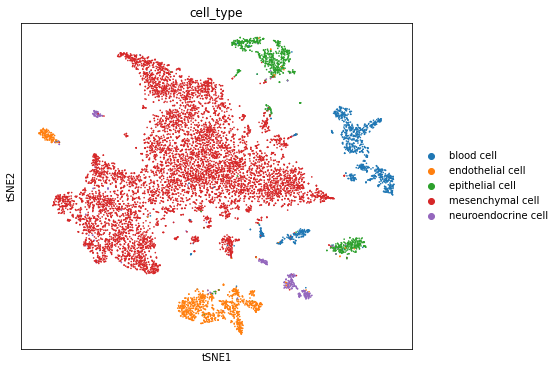

In [5]:
fig, ax = plt.subplots(figsize=(7, 6))
sc.pl.tsne(post_adata, color=["cell_type"], ax=ax, show=show_plot)

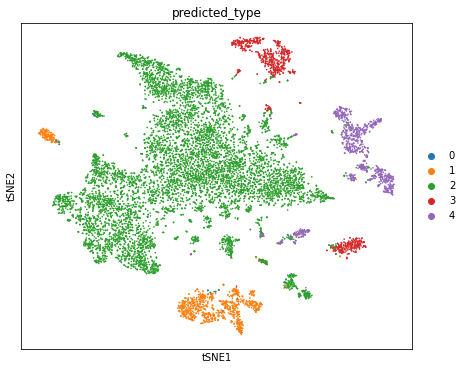

In [6]:
fig, ax = plt.subplots(figsize=(7, 6))
sc.pl.tsne(post_adata, color=["predicted_type"], ax=ax, show=show_plot)

In [7]:
print("Trachea_scziDesk_ARI: ")
print(ARI)
print("Trachea_scziDesk_NMI: ")
print(NMI)        

Trachea_scziDesk_ARI: 
0.88307
Trachea_scziDesk_NMI: 
0.8473


In [8]:
saved_data = anndata.AnnData(X=chencluster.embedding)
saved_data.obs['cell_type'] = post_adata.obs['cell_type']
saved_data.obs['predicted_type'] = post_adata.obs['predicted_type']
saved_data.obsm["default_visualization"] = post_adata.obsm["X_tsne"]
saved_data.uns["ari"] = ARI
saved_data.uns["nmi"] = NMI
saved_data.uns["default_visualization_method"] = 'tsne'
saved_data.write_h5ad("../../Saved_Data/scziDesk/Trachea_scziDesk.h5")